In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [128]:
#loading dataset
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [129]:
df['emotion_in_tweet_is_directed_at'].value_counts()

emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [130]:


# Assuming df is your DataFrame and 'column_name' is the column you want to check
# Replace 'column_name' with the actual name of the column
null_rows = df[df['emotion_in_tweet_is_directed_at'].isnull()]

# Now filter rows where all values are null in the specified column

# Print the rows
null_rows.iloc[-3]['tweet_text']


"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev"

In [158]:

# Assuming df is your DataFrame with 'tweet' and 'product' columns
# Replace 'tweet' with the name of your tweet column and 'product' with the name of your product column

# List of keywords related to Apple and Google
apple_keywords = ['apple', 'iphone', 'ipad', 'mac', 'ios']
google_keywords = ['google', 'android', 'pixel', 'chromebook']

# Function to check if a tweet contains keywords related to Apple or Google
def check_product(tweet):
    tweet_lower = tweet.lower()
    if any(keyword in tweet_lower for keyword in apple_keywords):
        return 'Apple'
    elif any(keyword in tweet_lower for keyword in google_keywords):
        return 'Google'
    else:
        return None

# Apply the function to each row in the DataFrame
null_rows['emotion_in_tweet_is_directed_at'] = null_rows['tweet_text'].apply(check_product)

# Print the DataFrame to see the updated 'product' column
print(null_rows)


AttributeError: 'float' object has no attribute 'lower'

In [174]:
import pandas as pd

# Assuming df is your DataFrame with 'tweet' and 'product' columns
# Replace 'tweet' with the name of your tweet column and 'product' with the name of your product column

# List of keywords related to Apple and Google
apple_keywords = ['apple', 'iphone', 'ipad', 'mac', 'ios','itunes']
google_keywords = ['google', 'android', 'pixel', 'chromebook','android','samsung']

# Function to check if a tweet contains keywords related to Apple or Google
def check_product(tweet):
    if isinstance(tweet, str):
        tweet_lower = tweet.lower()
        if any(keyword in tweet_lower for keyword in apple_keywords):
            return 'Apple'
        elif any(keyword in tweet_lower for keyword in google_keywords):
            return 'Google'
    return None

# Apply the function to each row in the DataFrame
# Apply the function to each row in the DataFrame
null_rows['emotion_in_tweet_is_directed_at'] = null_rows['tweet_text'].apply(check_product)

# Print the DataFrame to see the updated 'product' column
null_rows


C:\Users\ronal\AppData\Local\Temp\ipykernel_15728\176221669.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_rows['emotion_in_tweet_is_directed_at'] = null_rows['tweet_text'].apply(check_product)


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Apple,No emotion toward brand or product
6,NaN,None,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,Apple,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",Google,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,Apple,No emotion toward brand or product
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",Google,No emotion toward brand or product
9089,"Wave, buzz... RT @mention We interrupt your re...",Google,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",Google,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,Apple,No emotion toward brand or product


In [175]:
null_rows.isna().sum()

tweet_text                                              1
emotion_in_tweet_is_directed_at                       700
is_there_an_emotion_directed_at_a_brand_or_product      0
dtype: int64

In [177]:
null_rows_1 = null_rows[null_rows['emotion_in_tweet_is_directed_at'].isnull()]
null_rows_1[:5]['tweet_text']

6                                                   NaN
51    ï¿½ï¿½ï¿½@mention {link} &lt;-- HELP ME FORWAR...
52    ï¿½ï¿½ï¿½ WHAT? ï¿½ï¿½_ {link} ï¿½ï¿½_ #edchat...
53    .@mention @mention on the location-based 'fast...
66    At #sxsw? @mention / @mention wanna buy you a ...
Name: tweet_text, dtype: object

In [132]:
# null_rows.iloc[9090]['tweet_text']

In [133]:
# Successfully renamed the column for our convenience.
df.rename(columns={'emotion_in_tweet_is_directed_at':'emotion_towards','is_there_an_emotion_directed_at_a_brand_or_product':'emotion_reaction'},inplace=True)

In [134]:
df.head()

,tweet_text,emotion_towards,emotion_reaction
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [135]:
#explore the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_text        9092 non-null   object
 1   emotion_towards   3291 non-null   object
 2   emotion_reaction  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [136]:
df.isnull().sum()  # check missing values

tweet_text             1
emotion_towards     5802
emotion_reaction       0
dtype: int64

tweet_text: There is 1 missing value in the "tweet_text" column.
emotion_towards: There are 5802 missing values in the "emotion_towards" column.
emotion_reaction: There are no missing values (0) in the "emotion_reaction" column.

In [137]:
product_counts = df['emotion_towards'].value_counts()
print("\nProduct counts:")
print(product_counts)


Product counts:
emotion_towards
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64


In [138]:
# filling the null values
df1=df['emotion_towards'].mode()
df1

0    iPad
Name: emotion_towards, dtype: object

In [139]:
df['emotion_towards'].fillna(value='iPad',inplace=True)

C:\Users\ronal\AppData\Local\Temp\ipykernel_15728\3050321766.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['emotion_towards'].fillna(value='iPad',inplace=True)


In [140]:
df2=df['tweet_text'].mode()
df2

0    RT @mention Marissa Mayer: Google Will Connect...
Name: tweet_text, dtype: object

In [141]:
df['tweet_text'].fillna(value='RT @mention Marissa Mayer: Google Will Connect...',inplace=True)

C:\Users\ronal\AppData\Local\Temp\ipykernel_15728\3813208258.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['tweet_text'].fillna(value='RT @mention Marissa Mayer: Google Will Connect...',inplace=True)


In [142]:
# check if there is any missing values
df.isnull().sum()

tweet_text          0
emotion_towards     0
emotion_reaction    0
dtype: int64

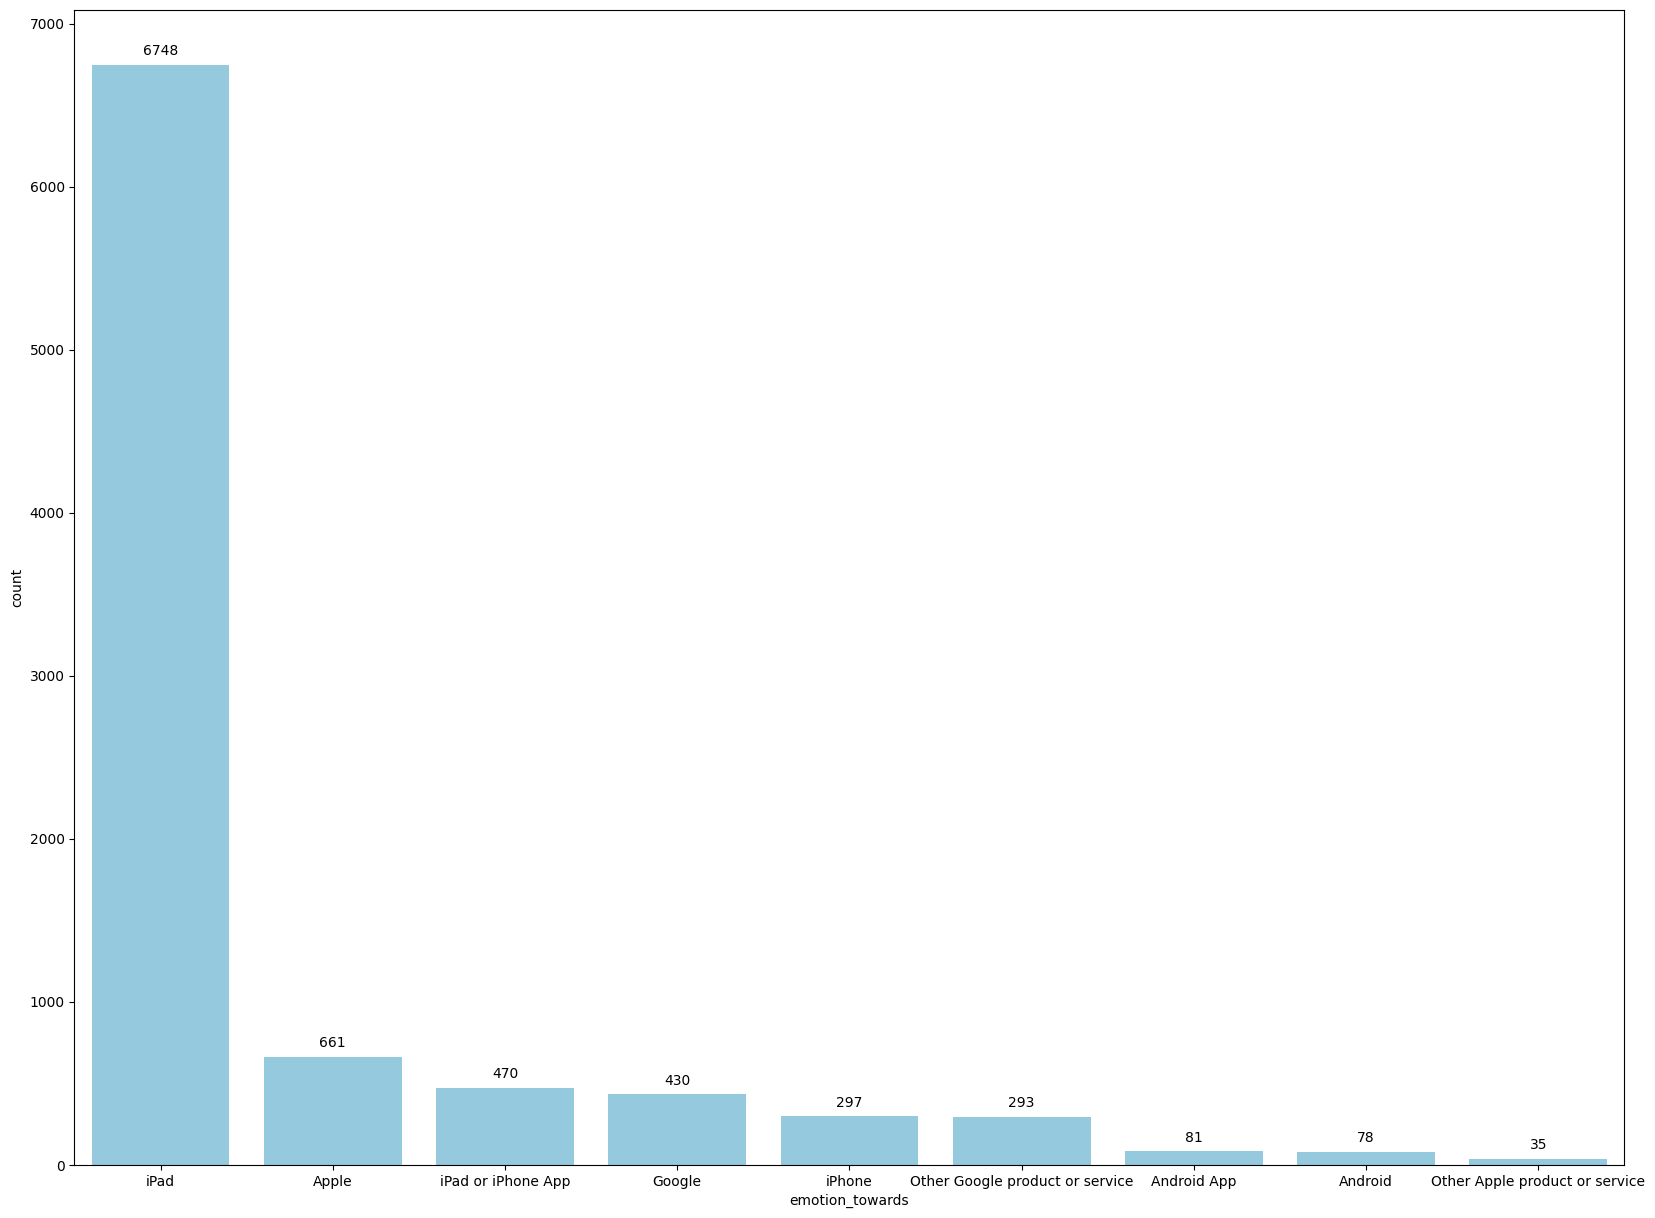

In [143]:
# Sort the DataFrame by the count of 'emotion_towards' in ascending order
sorted_df = df['emotion_towards'].value_counts().reset_index(name='count').sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(20, 15))
ax = sns.countplot(x='emotion_towards', data=df, order=sorted_df['emotion_towards'], color='skyblue')

# Add data labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

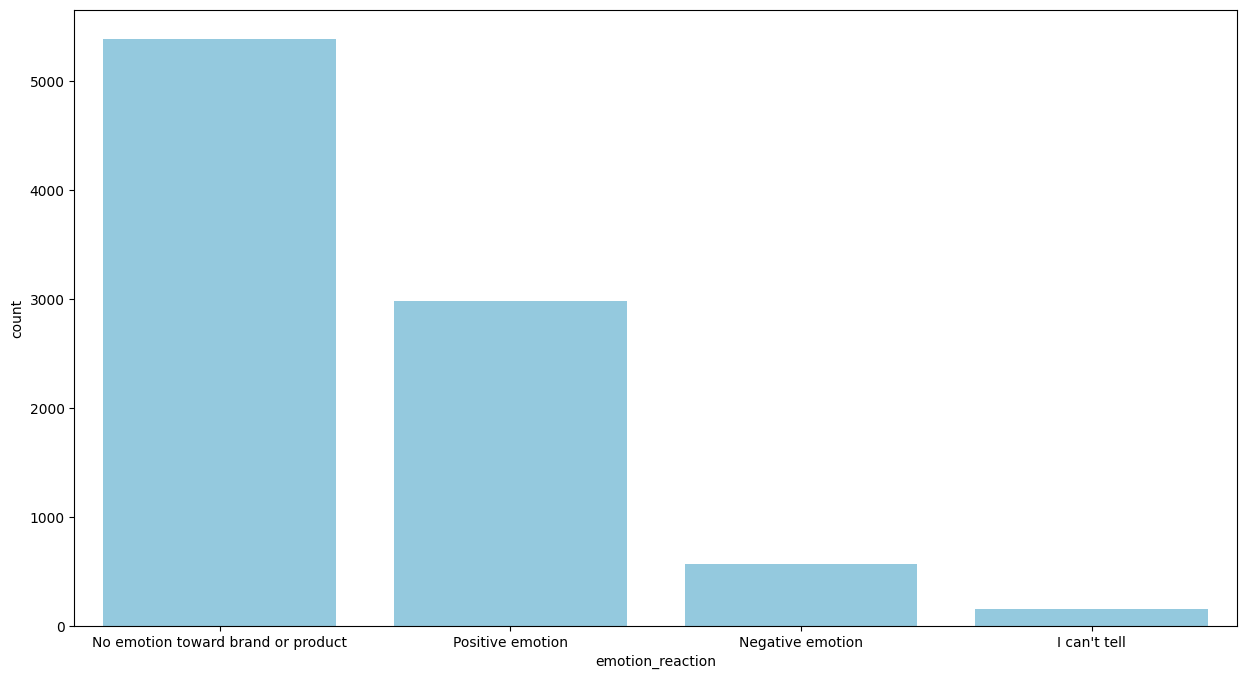

In [144]:
# Sort the DataFrame by the count of 'emotion_reaction' in descending order
sorted_df = df['emotion_reaction'].value_counts().reset_index(name='count').sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(15, 8))
sns.countplot(x='emotion_reaction', data=df, order=sorted_df['emotion_reaction'], color='skyblue')
plt.show()

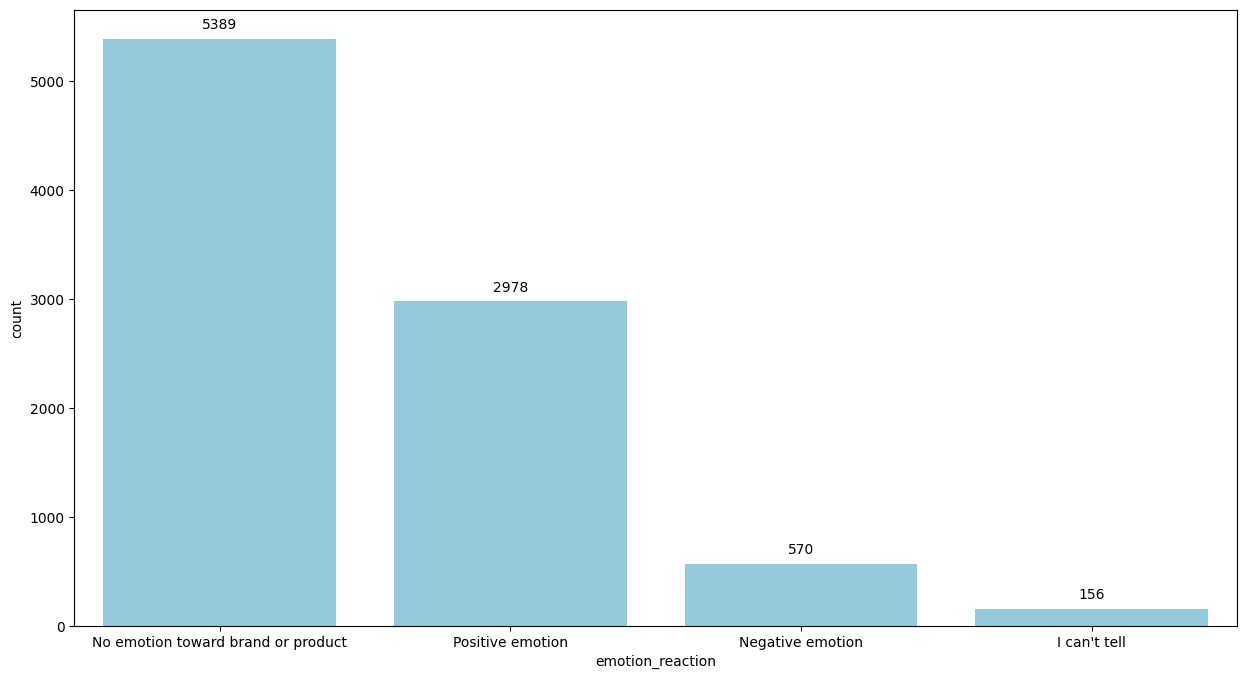

In [145]:
#  The count of 'emotion_reaction' in descending order
sorted_df = df['emotion_reaction'].value_counts().reset_index(name='count').sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='emotion_reaction', data=df, order=sorted_df['emotion_reaction'], color='skyblue')

# Add data labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()

<Figure size 2500x2000 with 0 Axes>

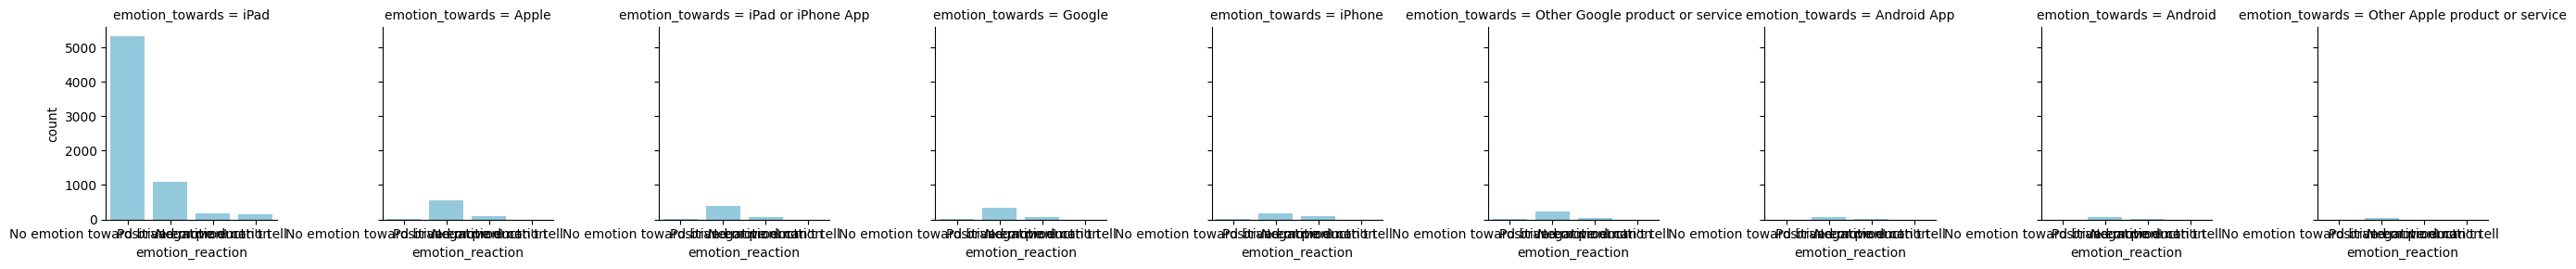

In [146]:
# Sort the DataFrame by the count of 'emotion_towards' in descending order
sorted_df = df['emotion_towards'].value_counts().reset_index(name='count').sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(25, 20))
g = sns.FacetGrid(df, col="emotion_towards", col_order=sorted_df['emotion_towards'])
g.map(sns.countplot, "emotion_reaction", order=df['emotion_reaction'].value_counts().index, color='skyblue')
plt.show()

In [147]:
df.describe()

,tweet_text,emotion_towards,emotion_reaction
count,9093,9093,9093
unique,9066,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,6748,5389


In [148]:
no_emotion_tweets = df[df['emotion_reaction'] == 'emotion_towards']['tweet_text']
no_emotion_tweets.count()

0

In [149]:
# Get unique emotions
unique_emotions = df['emotion_reaction'].unique()
unique_emotions

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [150]:
# Get counts of each emotion
emotion_counts = df['emotion_reaction'].value_counts()
# Sort emotions from highest to lowest
sorted_emotions = emotion_counts.sort_values(ascending=False)
sorted_emotions

emotion_reaction
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

In [151]:
df.columns

Index(['tweet_text', 'emotion_towards', 'emotion_reaction'], dtype='object')

In [152]:
unique_products = df['emotion_towards'].unique()
print("Unique products mentioned:")
print(unique_products)

Unique products mentioned:
['iPhone' 'iPad or iPhone App' 'iPad' 'Google' 'Android' 'Apple'
 'Android App' 'Other Google product or service'
 'Other Apple product or service']


In [153]:
product_counts = df['emotion_towards'].value_counts()
print("\nProduct counts:")
print(product_counts)


Product counts:
emotion_towards
iPad                               6748
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: count, dtype: int64


In [154]:
ipad_tweets = df[df['emotion_towards'] == 'iPad']['tweet_text']
print("\nRelevant tweets mentioning iPad:")
print(ipad_tweets.head())


Relevant tweets mentioning iPad:
2     @swonderlin Can not wait for #iPad 2 also. The...
5     @teachntech00 New iPad Apps For #SpeechTherapy...
6     RT @mention Marissa Mayer: Google Will Connect...
16    Holler Gram for iPad on the iTunes App Store -...
20    Need to buy an iPad2 while I'm in Austin at #s...
Name: tweet_text, dtype: object


In [155]:
ipad_tweets = df[df['emotion_towards'] == 'iPad']['tweet_text']
ipad_tweets

2       @swonderlin Can not wait for #iPad 2 also. The...
5       @teachntech00 New iPad Apps For #SpeechTherapy...
6       RT @mention Marissa Mayer: Google Will Connect...
16      Holler Gram for iPad on the iTunes App Store -...
20      Need to buy an iPad2 while I'm in Austin at #s...
                              ...                        
9088                        Ipad everywhere. #SXSW {link}
9089    Wave, buzz... RT @mention We interrupt your re...
9090    Google's Zeiger, a physician never reported po...
9091    Some Verizon iPhone customers complained their...
9092    ï¿½Ï¡ï¿½ï¿½ï¿½ï¿½ï¿½_ï¿½ï¿½Êï¿½Îï¿½Òï¿½ï¿½ï...
Name: tweet_text, Length: 6748, dtype: object

The dataframe has 9093 rows and 3 columns. 
All the data is of the object type which normally represents text or categorical data

The columns are named:
tweet_text 
    -contains 9092 non-null entries of text data (ie tweets)
emotion_in_tweet_is_directed_at 
    - Represents the emotion attached to a specific brand or product (e.g., “iPad”).
    - There are 3291 non-null entries.
    - The most frequent value is “iPad” (appears 946 times)
is_there_an_emotion_directed_at_a_brand_or_product
    -Indicates whether there is an emotion directed at a brand or product.
    -Four possible values:
        “Positive emotion”, “Negative emotion”,“No emotion toward brand or product” (appears 5389 times),“I can’t tell”
        


In [156]:
# Text cleaning
# remove capitalization, punctuation, stpowords and numbers
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Remove stopwords and numbers
    stop_words = set(stopwords.words('english'))
    clean_words = [word for word in words if word not in stop_words and not word.isdigit()]
    
    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(clean_words)
    
    return cleaned_text


In [157]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [126]:
# Example tweet text
tweet_text = ".@wesley83 I have a 3G iPhone. After 3 hrs twe..."

# Print original tweet text
print("Original Text:", tweet_text)

# Clean the tweet text
cleaned_text = clean_text(tweet_text)

# Print cleaned tweet text
print("Cleaned Text:", cleaned_text)

Original Text: .@wesley83 I have a 3G iPhone. After 3 hrs twe...
Cleaned Text: wesley83 3g iphone hrs twe
